In [2]:
import cv2
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
EPOCHS = 100
BS = 16
default_image_size = tuple((300, 300))
directory_root = '/content/drive/MyDrive/PLDD Dataset/PLDD Dataset'

In [4]:
# def convert_image_to_array(image_dir):
#     try:
#         image = cv2.imread(image_dir)
#         if image is not None:
#             image = cv2.resize(image, default_image_size)
#             return img_to_array(image)
#         else:
#             return np.array([])
#     except Exception as e:
#         print(f"Error: {e}")
#         return None

# image_list, label_list = [], []

# try:
#     print("[INFO] Loading images ...")
#     root_dir = os.listdir(directory_root)
#     for directory in root_dir:
#         if directory == ".DS_Store":
#             root_dir.remove(directory)

#     for plant_folder in root_dir:
#         plant_disease_folder_list = os.listdir(f"{directory_root}/{plant_folder}")
#         for disease_folder in plant_disease_folder_list:
#             if disease_folder == ".DS_Store":
#                 plant_disease_folder_list.remove(disease_folder)

#         for plant_disease_folder in plant_disease_folder_list:
#             print(f"[INFO] Processing {plant_disease_folder} ...")
#             plant_disease_image_list = os.listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

#             for single_plant_disease_image in plant_disease_image_list:
#                 if single_plant_disease_image == ".DS_Store":
#                     plant_disease_image_list.remove(single_plant_disease_image)

#             for image in plant_disease_image_list[:200]:  # Limiting to a smaller number for demonstration purposes
#                 image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
#                 if image_directory.endswith(".jpg") or image_directory.endswith(".JPG"):
#                     image_list.append(convert_image_to_array(image_directory))
#                     label_list.append(plant_disease_folder)
#     print("[INFO] Image loading completed")
# except Exception as e:
#     print(f"Error: {e}")



import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array

# Define required variables
directory_root = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset"  # Set correct path
default_image_size = (300, 300)  # Set the desired image size

# Function to convert image to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = os.listdir(directory_root)

    for directory in root_dir:
        if directory == ".DS_Store":
            root_dir.remove(directory)

    for plant_folder in root_dir:
        plant_folder_path = os.path.join(directory_root, plant_folder)
        if not os.path.isdir(plant_folder_path):  # Ensure it's a directory
            continue

        plant_disease_folder_list = os.listdir(plant_folder_path)
        for disease_folder in plant_disease_folder_list:
            if disease_folder == ".DS_Store":
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            plant_disease_folder_path = os.path.join(plant_folder_path, plant_disease_folder)
            if not os.path.isdir(plant_disease_folder_path):  # Ensure it's a directory
                continue

            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = os.listdir(plant_disease_folder_path)

            for single_plant_disease_image in plant_disease_image_list:
                image_directory = os.path.join(plant_disease_folder_path, single_plant_disease_image)

                if not os.path.isfile(image_directory):  # Ensure it's a file before processing
                    continue

                if image_directory.endswith((".jpg", ".JPG")):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error: {e}")


[INFO] Loading images ...
[INFO] Processing leaf spot ...
[INFO] Processing BLB ...
[INFO] Processing leaf folder ...
[INFO] Processing healthy ...
[INFO] Processing hispa ...
[INFO] Processing Blast ...
[INFO] Processing .ipynb_checkpoints ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

np_image_list = np.array(image_list, dtype=np.float16) / 255.0  # Normalize the pixel values

print("[INFO] Splitting data into train and test sets")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)

['BLB' 'Blast' 'healthy' 'hispa' 'leaf folder' 'leaf spot']
[INFO] Splitting data into train and test sets


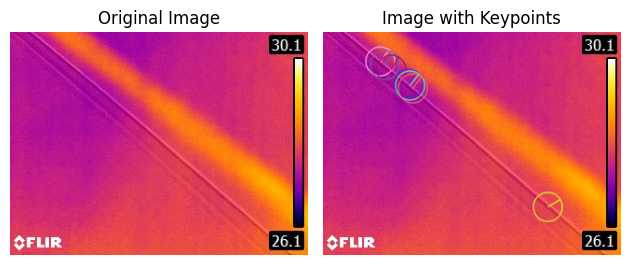

In [6]:
import cv2
def detect_keypoints(image_path):
    # Load the thermal image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    # Draw the keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return image_with_keypoints, keypoints

if __name__ == "__main__":
    # Replace 'thermal_image.jpg' with the path to your thermal plant image
    image_path = '/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/healthy/thermalimage2a.jpg'

    # Detect keypoints in the thermal image
    result_image, keypoints = detect_keypoints(image_path)

    # Show the original and keypoints-annotated images
    plt.subplot(121), plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title('Original Image'), plt.axis('off')

    plt.subplot(122), plt.imshow(result_image[:, :, ::-1])
    plt.title('Image with Keypoints'), plt.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define the path to the uploaded weights file
weights_path = "/content/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"

# Load the model with local weights
if os.path.exists(weights_path):
    print("Loading local weights...")
    base_model = MobileNetV2(weights=weights_path, include_top=False, input_shape=(300, 300, 3))
else:
    print("Weights file not found. Downloading from TensorFlow repository...")
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Unfreeze the last 20 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Create the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Loading local weights...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_300 (Functional)    │ (None, 10, 10, 1280)        │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,340,358 (8.93 MB)

 Trainable params: 1,288,454 (4.92 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [8]:
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 15:
        return initial_lr
    else:
        return initial_lr / 100

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Fit the model
history = model.fit(x_train, y_train,
                    batch_size=BS,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 508ms/step - accuracy: 0.4571 - loss: 2.6392 - val_accuracy: 0.3516 - val_loss: 9.1032 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7986 - loss: 1.5691 - val_accuracy: 0.5703 - val_loss: 7.2220 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8152 - loss: 1.2471 - val_accuracy: 0.5000 - val_loss: 9.1107 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8778 - loss: 1.0616 - val_accuracy: 0.3516 - val_loss: 22.1761 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9050 - loss: 0.8500 - val_accuracy: 0.4062 - val_loss: 13.1890 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9314 - loss: 0.7042 - val_accuracy: 0.3516 - val_loss: 24.3765 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9643 - loss: 0.5

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Calculate precision, f1 score, and confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9365 - loss: 0.3610
Test accuracy: 0.9296875
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step
Test Precision: 0.9429
Test Recall: 0.9297
Test F1 Score: 0.9313


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


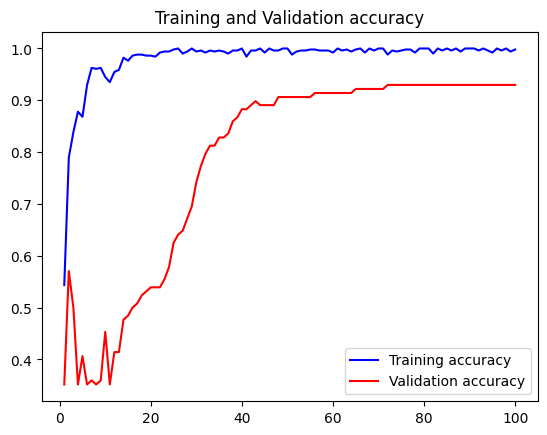

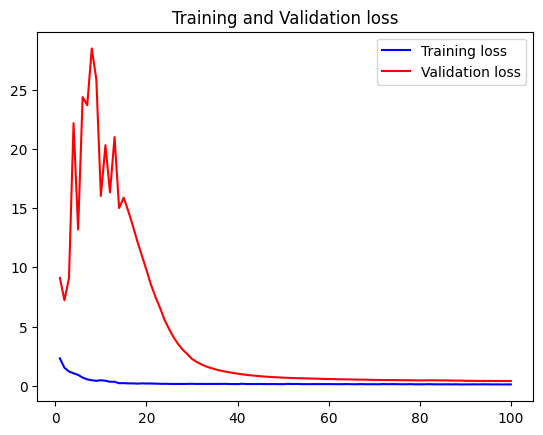

In [10]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [11]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9365 - loss: 0.3610
Test Accuracy: 92.96875


(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[8.9896648e-06 7.4140837e-07 9.9998891e-01 4.2716178e-07 3.1352636e-07
  4.8569632e-07]]
Predicted Class: healthy
Probability: 1.0000


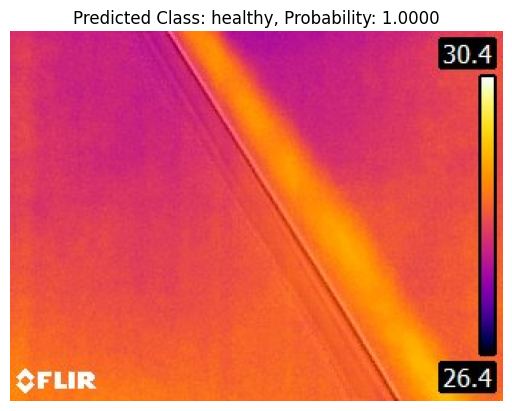

In [12]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/healthy/thermalimage4a.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
[[8.9555278e-06 6.5314205e-05 2.9824241e-07 9.9992466e-01 2.0928437e-07
  4.6694336e-07]]
Predicted Class: hispa
Probability: 0.9999


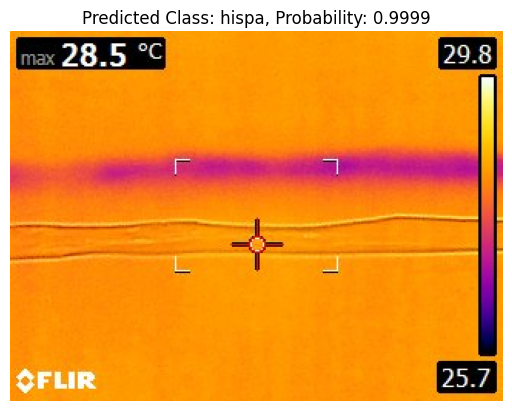

In [13]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/hispa/thermalimage58b.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[7.9613142e-07 9.9999845e-01 2.8628551e-07 5.3306690e-07 3.7221666e-09
  1.8805769e-08]]
Predicted Class: Blast
Probability: 1.0000


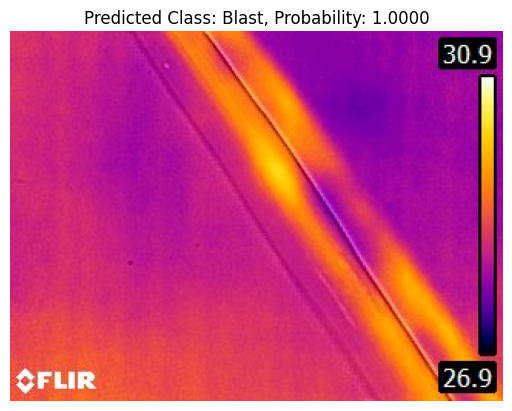

In [14]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/Blast/Thermalimage11b.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[3.5091722e-07 2.3420465e-07 3.2743099e-09 1.1031328e-06 9.9999833e-01
  5.5317567e-10]]
Predicted Class: leaf folder
Probability: 1.0000


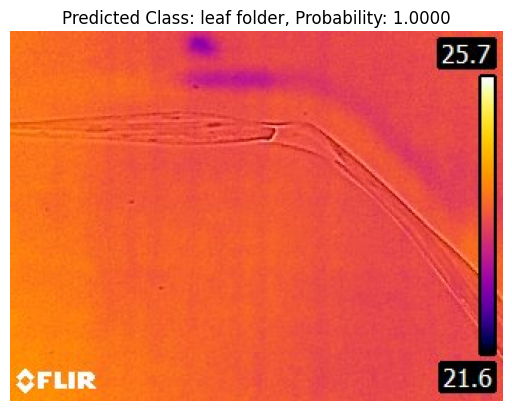

In [15]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/leaf folder/thermalimage13a.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[9.9999738e-01 6.0695711e-09 2.1107548e-06 1.9497688e-07 3.3439932e-08
  2.8038460e-07]]
Predicted Class: BLB
Probability: 1.0000


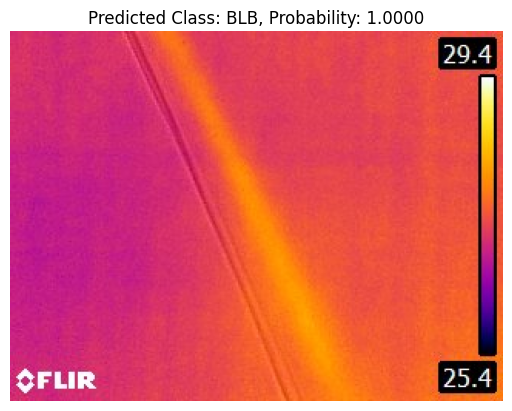

In [17]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/BLB/thermalimage101c.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[3.5288165e-05 3.1448308e-06 1.9906065e-05 1.0078647e-06 6.0844137e-08
  9.9994063e-01]]
Predicted Class: leaf spot
Probability: 0.9999


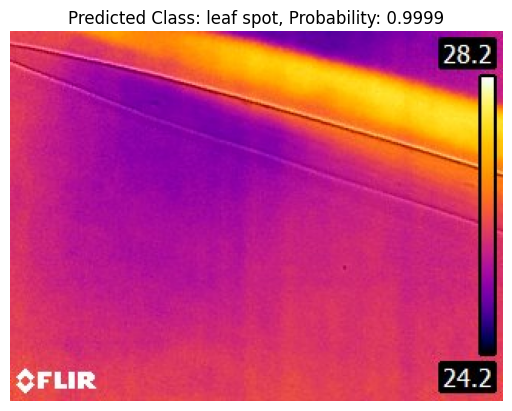

In [18]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Dataset/PLDD Dataset/thermal images UL/leaf spot/thermalimage12d.jpg"
im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

# Function to load and preprocess an image
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to generate GradCAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model for GradCAM using specified layers
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class with respect to activations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradient of the output neuron with respect to feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Calculate the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weighted sum of feature map channels to create heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Define the last convolutional layer name for MobileNetV2
last_conv_layer_name = "out_relu"

# Path to the image you want to generate a GradCAM heatmap for
img_path = '/kaggle/input/thermalimage/thermal images UL/BLB/thermalimage101c.jpg'

# Load MobileNetV2 model without default weights
model = MobileNetV2(weights=None, include_top=True)

# Check available files in weights directory
weights_path = "/kaggle/input/grad-wt"
print("Available files:", os.listdir(weights_path))

# Load manually uploaded weights (adjust filename if needed)
model.load_weights(os.path.join(weights_path, "mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224.h5"))

# Get the image array and generate the heatmap
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Rescale heatmap to 0-255
heatmap = np.uint8(255 * heatmap)

# Apply a colormap for visualization
plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.title('GradCAM Heatmap')
plt.show()